# HV scan with Trigger on Cosmic Rays

In questo script vengono analizzati i dati ottenuti triggerando sulle coincidenze


APERTURA di: ../../../Data/PMTgem/verticale_470.root
...(470) Caricamento Dati...
...Caricamento Dati Completato!...


...(470) Organizzazione Dati...
...Organizzazione Completata...


...Controllo Eventi Da Scartare...
...Eventi Scartati da ../../../Data/PMTgem/verticale_470.root: 30/6414


...(470) Rimozione Piedistallo...
...Piedistallo Rimosso...


...(470) Calcolo del Segnale in Corrente e Rimozione degli Eventi Da Scartare...
...Calcolo & Rimozione Completati...


...CONTROLLO -> Eventi Eliminati da ../../../Data/PMTgem/verticale_470.root 30


...(470) Calcolo dell'Integrale di Carica...
...Calcolo Eseguito...




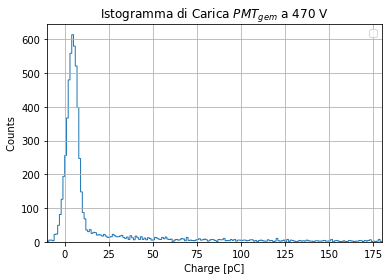

...(470) Calcolo del Valore Medio e Salvataggio...
---- Analisi su ../../../Data/PMTgem/verticale_470.root COMPLETATA! ----


----- ANALISI GENERALE CONCLUSA!!!! ------
 FCN=48.8353 FROM MIGRAD    STATUS=CONVERGED      68 CALLS          69 TOTAL
                     EDM=4.28494e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     5.75714e+02   1.06768e+01   3.04110e-02  -2.74960e-05
   2  Mean         4.75892e+00   1.07511e-01   2.35698e-04  -6.89351e-04
   3  Sigma        3.61781e+00   7.93532e-02   1.37869e-05  -1.76861e-02


Info in ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 


In [23]:
import ROOT as root
import numpy as np
import matplotlib.pyplot as plt

from ROOT import TMath , TF1, TH1F
import scipy.stats as st 

#from ROOT import TMath , TCanvas , TGraph , TH1D

#number = 360

voltage = [470]# 103, 102 , 104 ]


#definisco degli array in cui salvare dinamicamente i valori da graficare
means = []
errors = []
hv = []

dataset1 = []
dataset1Blu = []
dataset1Verde = []

dataset2 = []
dataset2Blu = []
dataset2Verde = []

dataset3 = []
dataset3Blu = []
dataset3Verde = []


pied1 = []
pied2 = []
pied3 = []


for number in voltage: #ciclo che permette di aprire tutti i file in sequenza
    filename = '../../../Data/PMTgem/verticale_%s.root'%(str(number)) #_%s_1000eventi.root'%(str(number))
    #filename = 'scanED2000.root'
    print("\nAPERTURA di: " + filename)
    
    fileROOT = root.TFile(filename)#"chargeDataBlu.root") #nome del rootfile
    tree = fileROOT.Get("t1") #nome del datatree

    n = 1024
    nCh = 4
    nDat = n*nCh #numero dati per evento...vengono salvati in riga tutti i canali
    nEvts = tree.GetEntries() #numero di eventi
    
    wave = np.zeros((nEvts,nDat))
    time = np.zeros((nEvts,nDat))
    
    print('...(%d) Caricamento Dati...'%(number))
    i=0
    for dat in tree:
        wave[i] = np.array(dat.wave_array)
        time[i] = np.array(dat.time_array)
        i = i+1    

    print('...Caricamento Dati Completato!...\n\n')

    waveCh1 = np.zeros((nEvts,n))
    waveCh2 = np.zeros((nEvts,n))
    waveCh3 = np.zeros((nEvts,n))
    waveCh4 = np.zeros((nEvts,n))

    timeCh1 = np.zeros((nEvts,n))
    timeCh2 = np.zeros((nEvts,n))
    timeCh3 = np.zeros((nEvts,n))
    timeCh4 = np.zeros((nEvts,n))
    
    print('...(%d) Organizzazione Dati...'%(number))
    
    for i in range(nEvts):
        for j in range(nDat):
            if j < nDat/4:
                waveCh1[i][j] = wave[i][j]
                timeCh1[i][j] = time[i][j]
            elif j >= nDat/4 and j < nDat/2:
                waveCh2[i][j-n] = wave[i][j]
                timeCh2[i][j-n] = time[i][j]
            elif j >= nDat/2 and j < nDat*3/4:
                waveCh3[i][j-2*n] = wave[i][j]
                timeCh3[i][j-2*n] = time[i][j]
            elif j >= nDat*3/4: 
                waveCh4[i][j-3*n] = wave[i][j]
                timeCh4[i][j-3*n] = time[i][j]

    print('...Organizzazione Completata...\n\n')
    j = 0
    print('...Controllo Eventi Da Scartare...')
    for i in range(nEvts):
        if min(waveCh4[i]) < -110 and waveCh4[i].argmin() < 5: 
            #print(i , waveCh4[i].argmin() , timeCh4[i][waveCh4[i].argmin()])
            j = j+1
    print('...Eventi Scartati da ' + filename + ': ' + str(j) + '/' + str(nEvts) + '\n\n')
    
    print('...(%d) Rimozione Piedistallo...'%(number))

    piedistallo = np.zeros((nEvts , 100))
    for i in range(nEvts):
        waveCh4[i] = waveCh4[i]-np.mean(waveCh4[i][0:100])
    print("...Piedistallo Rimosso...\n\n")
    
    print('...(%d) Calcolo del Segnale in Corrente e Rimozione degli Eventi Da Scartare...'%(number))
   
    waveCh4A = np.zeros((nEvts,n))
    
    waveCh2A = np.zeros((nEvts-j+50,n))
    waveCh3A = np.zeros((nEvts-j+50,n))
  
    R = 50 #resistenza in Ohm
    piedistallo = np.zeros((nEvts-j+50,400))
   
    k=0
    for i in np.arange(1,nEvts):
        #butto gli eventi con il picco strano
        if min(waveCh4[i]) >= -110 or ( min(waveCh4[i])< -110  and waveCh4[i].argmin() != 1 ):
            waveCh4A[k] = waveCh4[i]/R #conversione dati Tensione -> dati Corrente
            waveCh2A[k] = waveCh2[i]/R #blu
            waveCh3A[k] = waveCh3[i]/R #verde
            #if(min(waveCh4A[k])<= -40)
            
            piedistallo[k] = waveCh4[i][0:400]/R
            #piedistallo[i][401:] = waveCh4[i][801:]/R
            k = k+1
        else: 1 
            #print(min(waveCh4[i]) , waveCh4[i].argmin() , i) #check

    print('...Calcolo & Rimozione Completati...\n\n')
            
    print('...CONTROLLO -> Eventi Eliminati da ' + filename + ' ' + str(nEvts - k) + '\n\n')#check
    
    print('...(%d) Calcolo dell\'Integrale di Carica...'%(number))
    integral = np.zeros(k)
    integralB = np.zeros(k)
    integralV = np.zeros(k)
    
    integralP = np.zeros(k)
    #Eseguo l'Integrale
    
    #file = open("histoCarica"+str(number)+".dat", "w")
    for i in range(k):
        integral[i] = sum(-waveCh4A[i])
        integralB[i] = sum(-waveCh2A[i][400:800])
        integralV[i] = sum(-waveCh3A[i][400:800])
        
        integralP[i] = sum(-piedistallo[i])
     #   file.write(str(integral[i])+"\t" + str(integralB[i]) + "\t" +str(integralV[i]) + "\n")
    #file.close()
    
    #if number == 480:#102:
    #    for data in integral:
    #        dataset1.append(data)
    #    for data in integralB:
    #        dataset1Blu.append(data)
    #    for data in integralV:
    #        dataset1Verde.append(data)
    #        
    #    for p in integralP:
    #        pied1.append(p)
    #
    #elif number == 490:
    #    for data in integral:
    #        dataset2.append(data)
    #    for data in integralV:
    #        dataset2Verde.append(data)
    #    for data in integralB:
    #        dataset2Blu.append(data)
    #    
    #    for p in integralP:
    #        pied2.append(p)
    #    
    #elif number == 470:
    #    for data in integral:
    #        dataset3.append(data)
    #    for data in integralV:
    #        dataset3Verde.append(data)
    #    for data in integralB:
    #        dataset3Blu.append(data)
    #    
    #    for p in integralP:
    #        pied3.append(p)
    print('...Calcolo Eseguito...\n\n')

    #c = TCanvas()
    #g = TGraph(x.size, x.astype(np.double),y.astype(np.double))
    #fit = g.Fit("gaus" , "S")
    
    #g.Draw("AP")
   
    #----FIT e GRAFICO ISTOGRAMMA----

    xmin = min(integral)
   
    h1 = TH1F( "h1", "Istogramma di Carica $PMT_{gem}$ a %d V ; Charge [pC] ; Counts "%(number), 3050, -50, 3000 )
    for i in integral:
        h1.Fill(i)
       
    xmax = h1.GetBinCenter(h1.GetMaximumBin())#max(integral)#  #è la x del max dell'istogramma
    
    l = np.linspace(xmin , xmax+3 , len(integral))
    func = TF1("fitF" , "gaus" , xmin , xmax+3)
    func.SetParLimits(1 , xmax-1 , xmax+1) 
    #func.SetParLimits(0 , h1.GetMaximum() , h1.GetMaximum())
    
    h1.Fit("fitF" , "R")
    
    #uso la normale definita in scipy usando i parametri estratti dal fit
    pdf = st.norm.pdf(l , func.GetParameter(1) , func.GetParameter(2)) 

    from rootplot import root2matplotlib as r2m
    
    histo1 = r2m.Hist(h1) #permette di leggere l'istogramma già riempito da root
    histo1.hist(histtype = 'step' , fill = False) #fa l'istogramma
    #plt.plot(l , pdf*func.GetParameter(0)/max(pdf) , label = 'Fit' , color = 'r') 
    plt.grid()
    plt.xlim((-10,180))
    plt.legend()
    histo1.show_titles()
   ##plt.xlabel('Charge [pC]')
   ##plt.ylabel('Counts')
   ##plt.title(')
    plt.savefig('histo'+ str(number) + '.png')
    plt.show()

    #----------------------------
    
    print('...(%d) Calcolo del Valore Medio e Salvataggio...'%(number))
    
    #print(np.mean(integral) , func.GetParameter(1))

    means.append(np.mean(integral))#func.GetParameter(1))#
    errors.append(func.GetParameter(2)/np.sqrt(len(integral)))#func.GetParError(1))#
    hv.append(number)
    
    
    
    
    
#fine analisi
    print('---- Analisi su ' + filename + ' COMPLETATA! ----\n\n')
   # number += 10
    
print('----- ANALISI GENERALE CONCLUSA!!!! ------')

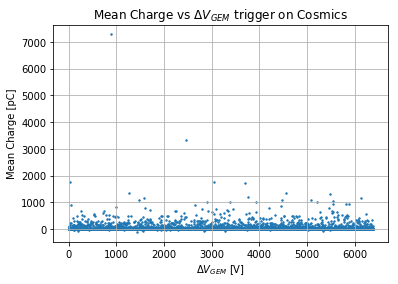

6384


In [27]:
#plt.errorbar(np.array(hv) , np.array(means) , yerr = np.array(errors) , fmt = "*" , capsize = 5 , elinewidth = 1)
plt.scatter(np.arange(len(integral)) , integral , s = 2)
#plt.plot(np.arange(len(integral)))
plt.grid()
plt.xlabel('$\Delta V_{GEM}$ [V]')
plt.ylabel('Mean Charge [pC]')
plt.title('Mean Charge vs $\Delta V_{GEM}$ trigger on Cosmics')
#plt.savefig('CaricaVsHVCosmici.png')
plt.show()
print(len(integral))

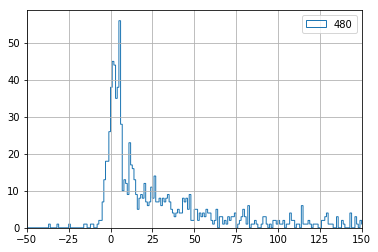

In [5]:
maxBin = 3000.
minBin = -50.
nBin = 3050.
binw = (maxBin-minBin)/nBin

plt.hist(np.array(dataset1) , histtype = 'step' , fill = False , label = '480' , bins = np.arange(minBin , maxBin+binw , binw))
#plt.hist(np.array(pied1) , histtype = 'step' , fill = False , label = 'piedistallo480', bins = np.arange(minBin , maxBin+binw , binw))

#plt.hist(np.array(dataset2) , histtype = 'step' , fill = False , label = '490' , bins = np.arange(minBin , maxBin+binw , binw))
#plt.hist(np.array(pied2) , histtype = 'step' , fill = False , label = 'piedistallo490' , bins = np.arange(minBin , maxBin+binw , binw))

#plt.hist(np.array(dataset3) , histtype = 'step' , fill = False , label = '470' , bins = np.arange(minBin , maxBin+binw , binw))
#plt.hist(np.array(pied3) , histtype = 'step' , fill = False , label = 'piedistallo470' , bins = np.arange(minBin , maxBin+binw , binw))


#plt.yscale("log")
plt.xlim((-50 , 150))
plt.legend()
plt.grid()
#plt.savefig('piedistallo480.png')
plt.show()
